# Sentiment Analysis and Recommender Systems Part 3 - Exercises with Results

## Exercise 1

#### Task 1 
##### Load libraries that are used in this module.

#### Result:

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy.sparse.linalg import svds
from surprise import Reader
from surprise import Dataset
from surprise import SVD
from surprise.model_selection import cross_validate

#### Task 2 

##### Set working directory to folder where the dataset is present.

#### Result:

In [2]:
from pathlib import Path
home_dir = Path(".").resolve()
main_dir = home_dir.parent.parent

data_dir = str(main_dir) + "/data"


#### Task 3
##### Read in 'lastfm_ratings.csv' dataset to a dataframe named 'fm_ratings' and 'lastfm_artists.csv' as 'fm_artists'.
##### Print the info and head of the dataset.

#### Result:

In [3]:
fm_ratings = pd.read_csv(data_dir + '/lastfm_ratings.csv')
fm_artists = pd.read_csv(data_dir + '/lastfm_artists.csv')

In [4]:
fm_ratings.head()

,userID,artistID,rating,artist_name,genre
0,4,51,4.0,Duran Duran,new wave| 80s| new wave| 80s| new wave| synth ...
1,27,51,2.0,Duran Duran,new wave| 80s| new wave| 80s| new wave| synth ...
2,28,51,1.0,Duran Duran,new wave| 80s| new wave| 80s| new wave| synth ...
3,62,51,7.0,Duran Duran,new wave| 80s| new wave| 80s| new wave| synth ...
4,63,51,7.0,Duran Duran,new wave| 80s| new wave| 80s| new wave| synth ...


In [5]:
fm_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68314 entries, 0 to 68313
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   userID       68314 non-null  int64  
 1   artistID     68314 non-null  int64  
 2   rating       68314 non-null  float64
 3   artist_name  68314 non-null  object 
 4   genre        68314 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 2.6+ MB


In [6]:
fm_artists.head()

,artistID,artist_name,genre
0,51,Duran Duran,new wave| 80s| new wave| 80s| new wave| synth ...
1,52,Morcheeba,chillout| downtempo| electronic| trip-hop| fem...
2,53,Air,electronic| autumn| downtempo| electronic| tri...
3,54,Hooverphonic,relax| electronic| female vocalist| trip-hop| ...
4,55,Kylie Minogue,seen live| electronic| pop| dance| pop dance| ...


In [7]:
fm_artists.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11065 entries, 0 to 11064
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   artistID     11065 non-null  int64 
 1   artist_name  11065 non-null  object
 2   genre        11065 non-null  object
dtypes: int64(1), object(2)
memory usage: 259.5+ KB


#### Task 4
##### Print a word cloud to find which words are repeated in the `artist_name` using fm_artists dataframe.

#### Result:

(-0.5, 3999.5, 1999.5, -0.5)

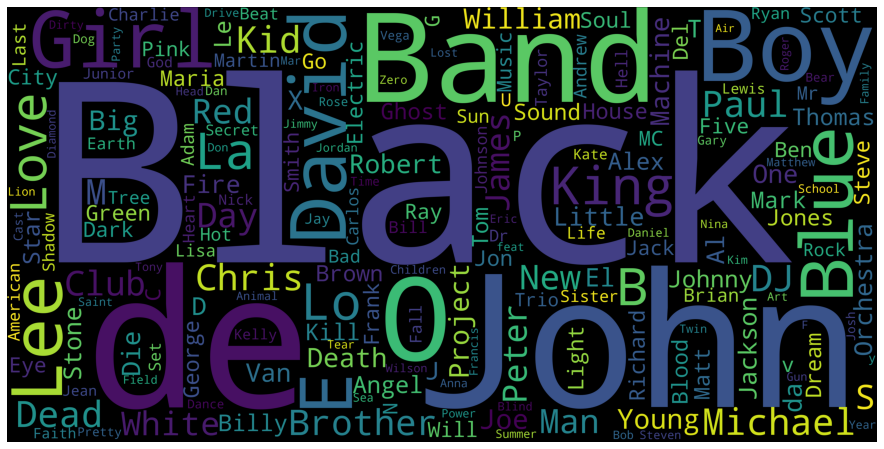

In [8]:
# Create a word cloud of the artists' titles.
fm_artists['artist_name'] = fm_artists['artist_name'].fillna("").astype('str')
title_corpus = ' '.join(fm_artists['artist_name'])
title_wordcloud = WordCloud(stopwords = STOPWORDS, background_color = 'black', 
                            height=2000, width=4000).generate(title_corpus)

# Plot the word cloud.
plt.figure(figsize = (16, 8))
plt.imshow(title_wordcloud)
plt.axis('off')

#### Task 5
##### Find the distribution of `rating` by plotting a count plot in fm_ratings dataframe.

#### Result:

In [9]:
# Get summary statistics of rating.
fm_ratings['rating'].describe()

count    68314.000000
mean         3.830898
std          2.318058
min          1.000000
25%          2.000000
50%          3.000000
75%          5.000000
max         10.000000
Name: rating, dtype: float64

<AxesSubplot:xlabel='rating', ylabel='count'>

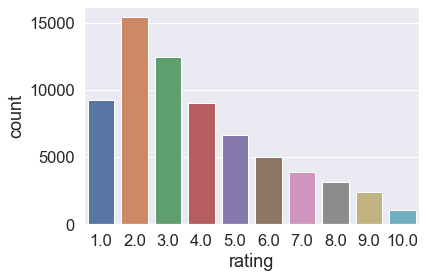

In [10]:
sns.set_style('whitegrid')
sns.set(font_scale = 1.5)

# Display distribution of rating.
sns.countplot(x='rating', data=fm_ratings)

#### Task 6
##### Fetch all the genres in the dataset and print top 5 using the function we used in the module.

In [11]:
# Function that counts the number of times each of the genre keywords appear.
def count_word(dataset, ref_col, census):
    keyword_count = dict()
    for s in census: 
        keyword_count[s] = 0
    for census_keywords in dataset[ref_col].str.split('|'):        
        if type(census_keywords) == float and pd.isnull(census_keywords): 
            continue        
        for s in [s for s in census_keywords if s in census]: 
            if pd.notnull(s): 
                keyword_count[s] += 1

    # Convert the dictionary in a list to sort the keywords by frequency.
    keyword_occurrences = []
    for k,v in keyword_count.items():
        keyword_occurrences.append([k,v])
    keyword_occurrences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurrences, keyword_count

#### Result:

In [12]:
# Make a census of the genre keywords.
genre_labels = set()
for s in fm_artists['genre'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

In [13]:
# Calling this function gives access to a list of genre keywords which 
# are sorted by decreasing frequency.
keyword_occurrences, dum = count_word(fm_artists, 'genre', genre_labels)
keyword_occurrences[:5]

[[' rock', 6754],
 [' alternative', 4882],
 [' pop', 4679],
 [' indie', 4078],
 [' electronic', 4025]]

## Exercise 2

#### Task 1
##### We will build a content based recommender system using `fm_artists` dataframe.
##### Convert the `genre` to string array.
##### Calculate the TF-IDF matrix.

#### Result:

In [14]:
# Break up the big genre string into a string array.
fm_artists['genre'] = fm_artists['genre'].str.split('|')

# Convert genres to string values.
fm_artists['genre'] = fm_artists['genre'].fillna("").astype('str')
fm_artists['genre'].head()

0    ['new wave', ' 80s', ' new wave', ' 80s', ' ne...
1    ['chillout', ' downtempo', ' electronic', ' tr...
2    ['electronic', ' autumn', ' downtempo', ' elec...
3    ['relax', ' electronic', ' female vocalist', '...
4    ['seen live', ' electronic', ' pop', ' dance',...
Name: genre, dtype: object

In [15]:
tf = TfidfVectorizer(analyzer = 'word', 
                     ngram_range = (1, 2), 
                     min_df = 0,  
                     stop_words = 'english')

tfidf_matrix = tf.fit_transform(fm_artists['genre'])
tfidf_matrix.shape

(11065, 52490)

#### Task 2
##### Build the cosine similarity of the artists, call it 'cosine_sim', and print the top entries in that matrix.
##### Also, print the shape of the cosine similarity matrix.
##### Build the list of artists' titles, and label it `indices`.

#### Result:

In [16]:
# Consine similarity for all artists.
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim[:4, :4]

array([[1.        , 0.01875779, 0.04932386, 0.02676505],
       [0.01875779, 1.        , 0.43918315, 0.82512665],
       [0.04932386, 0.43918315, 1.        , 0.47910804],
       [0.02676505, 0.82512665, 0.47910804, 1.        ]])

In [17]:
cosine_sim.shape

(11065, 11065)

In [18]:
# Build a 1-dimensional array with the artists' titles.
titles = fm_artists['artist_name']
indices = pd.Series(fm_artists.index, index = fm_artists['artist_name'])
titles[0:5]

0      Duran Duran
1        Morcheeba
2              Air
3     Hooverphonic
4    Kylie Minogue
Name: artist_name, dtype: object

#### Task 3
##### Use the function to return top similar artists based on the cosine similarity value for any given artist name.
##### Find recommendations for a person who likes 'Rihanna' in their playlist.
##### Also, find recommendations for someone who likes 'Madonna'.

In [19]:
# Function that get artists recommendations based on the cosine similarity score of artists.
def genre_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

#### Result:

In [20]:
genre_recommendations('Rihanna').head(20)

219                  Ciara
200                Beyoncé
742        Destiny's Child
249     The Pussycat Dolls
224                 Fergie
217                 Cassie
190          Janet Jackson
427     Nicole Scherzinger
204         Jennifer Lopez
4922        Jessica Mauboy
409           Gwen Stefani
4580          Brick & Lace
197     Christina Aguilera
215          Nelly Furtado
201              Sugababes
507                 Hadise
9296                 Honey
4            Kylie Minogue
34               Lady Gaga
167           Mariah Carey
Name: artist_name, dtype: object

In [21]:
genre_recommendations('Madonna').head(20)

4            Kylie Minogue
241                   Cher
34               Lady Gaga
507                 Hadise
9296                 Honey
194         Britney Spears
409           Gwen Stefani
197     Christina Aguilera
190          Janet Jackson
354                  Ke$ha
2066                 Robyn
193                Rihanna
1693             September
222            Hilary Duff
799               t.A.T.u.
407          Lindsay Lohan
205             Katy Perry
3667           Paula Abdul
215          Nelly Furtado
279                Cascada
Name: artist_name, dtype: object